In [2]:
import os
import numpy as np
import pandas as pd
from definitions import DATA_DIR, REPORT_DIR

In [3]:
# Load both DataFrames, parsing the time columns as datetime
df_vwap = pd.read_csv(
    os.path.join(DATA_DIR, "binance_vision", "spot", "aggTrades", "vwap_BTCUSDT_combined.csv"),
    parse_dates=["timestamp"]
)
df_actions = pd.read_csv(
    os.path.join(REPORT_DIR, "optimal_actions", "final_combined_actions.csv"),
    parse_dates=["Opened"]
)

# Rename columns in df_vwap so we can merge on the same key and distinguish its Volume
df_vwap.rename(columns={"timestamp": "Opened", "Volume": "Volume_2"}, inplace=True)

# Merge df_actions with df_vwap (keeping only rows present in df_actions)
df_merged = df_actions.merge(df_vwap, on="Opened", how="left")

# Reorder columns: insert 'vwap' immediately after df_actions' 'Volume', and append df_vwap's Volume as 'Volume_2'
base_cols = list(df_actions.columns)
insert_at = base_cols.index("Volume") + 1
ordered = base_cols[:insert_at] + ["VWAP"] + base_cols[insert_at:] + ["Volume_2"]

df_final = df_merged[ordered]

# Preview
df_final.head()


,Opened,Open,High,Low,Close,Volume,VWAP,Action,Weight,Volume_2
0,2018-01-01 00:00:00,13829.97,13829.99,13645.03,13716.36,246.453106,13519.400089,0,1.000000,443.356199
1,2018-01-01 01:00:00,13528.99,13595.89,13155.38,13203.06,383.697006,13433.833141,1,1.029368,383.697006
2,2018-01-01 02:00:00,13203.00,13418.43,13200.00,13330.18,429.064572,13308.467749,0,1.029368,429.064572
3,2018-01-01 03:00:00,13330.26,13611.27,13290.00,13410.03,420.087030,13467.324752,0,1.029368,420.087030
4,2018-01-01 04:00:00,13434.98,13623.29,13322.15,13601.01,340.807329,13462.289704,-1,1.029368,340.807329


In [4]:
import numpy as np
import pandas as pd

def add_volume_profile_fixed_range(
        df: pd.DataFrame,
        price_min: float = 1,
        price_max: float = 1_000_000,
        step: float = 5,
        bins_back: int = 2,
        bins_forward: int = 2
    ) -> pd.DataFrame:
    """
    Dodaje do df kolumny VP_bin_pct_{±k} opisujące względny wolumen
    w sąsiednich binach, korzystając z **stałej** siatki cenowej.
    """

    # --- 0. Przygotowanie stałej siatki cenowej ------------------------------
    price_levels = np.arange(price_min, price_max + step, step, dtype=float)
    bins = len(price_levels) - 1                        # 200 000 przy domyślnych ustawieniach
    volume_profile = np.zeros(bins, dtype=float)        # 1.6 MB w float64 – dość lekkie

    # --- 1. Przygotowanie roboczej kopii i kolumn na wynik -------------------
    df = df.copy().reset_index(drop=True)
    shifts = [s for s in range(-bins_back, bins_forward + 1) if s != 0]
    for s in shifts:
        df[f"VP_bin_pct_{s:+}"] = np.nan

    # --- 2. Funkcje pomocnicze ------------------------------------------------
    def get_bin_idx(price):
        """Zwraca indeks biniu 0..bins-1 dla podanej ceny (z ucięciem do krańców)."""
        idx = np.searchsorted(price_levels, price, side="right") - 1
        return np.clip(idx, 0, bins - 1)

    # --- 3. Pętla po świecach -------------------------------------------------
    for i, (low_i, high_i, vwap_i, vol_i) in df[["Low", "High", "VWAP", "Volume"]].iterrows():

        # 3.1. Bieżący bin VWAP + relacje wolumenowe
        bin_idx = get_bin_idx(vwap_i)
        curr_vol = volume_profile[bin_idx]

        for s in shifts:
            nb = np.clip(bin_idx + s, 0, bins - 1)
            neigh_vol = volume_profile[nb]
            col = f"VP_bin_pct_{s:+}"
            df.at[i, col] = 0.0 if curr_vol == 0 else (neigh_vol - curr_vol) / curr_vol

        # 3.2. Dopiero teraz aktualizujemy profil wolumenu
        start = get_bin_idx(low_i)
        end   = get_bin_idx(high_i)
        volume_profile[start:end + 1] += vol_i

    return df

In [5]:
df = add_volume_profile_fixed_range(
        df_final,
        price_min=1,          # jeśli znasz realny dolny próg instrumentu
        price_max=1_000_000,
        step=5,
        bins_back=100,
        bins_forward=100
     )

C:\Users\philipz\AppData\Local\Temp\ipykernel_22084\2179939997.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"VP_bin_pct_{s:+}"] = np.nan
C:\Users\philipz\AppData\Local\Temp\ipykernel_22084\2179939997.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"VP_bin_pct_{s:+}"] = np.nan
C:\Users\philipz\AppData\Local\Temp\ipykernel_22084\2179939997.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

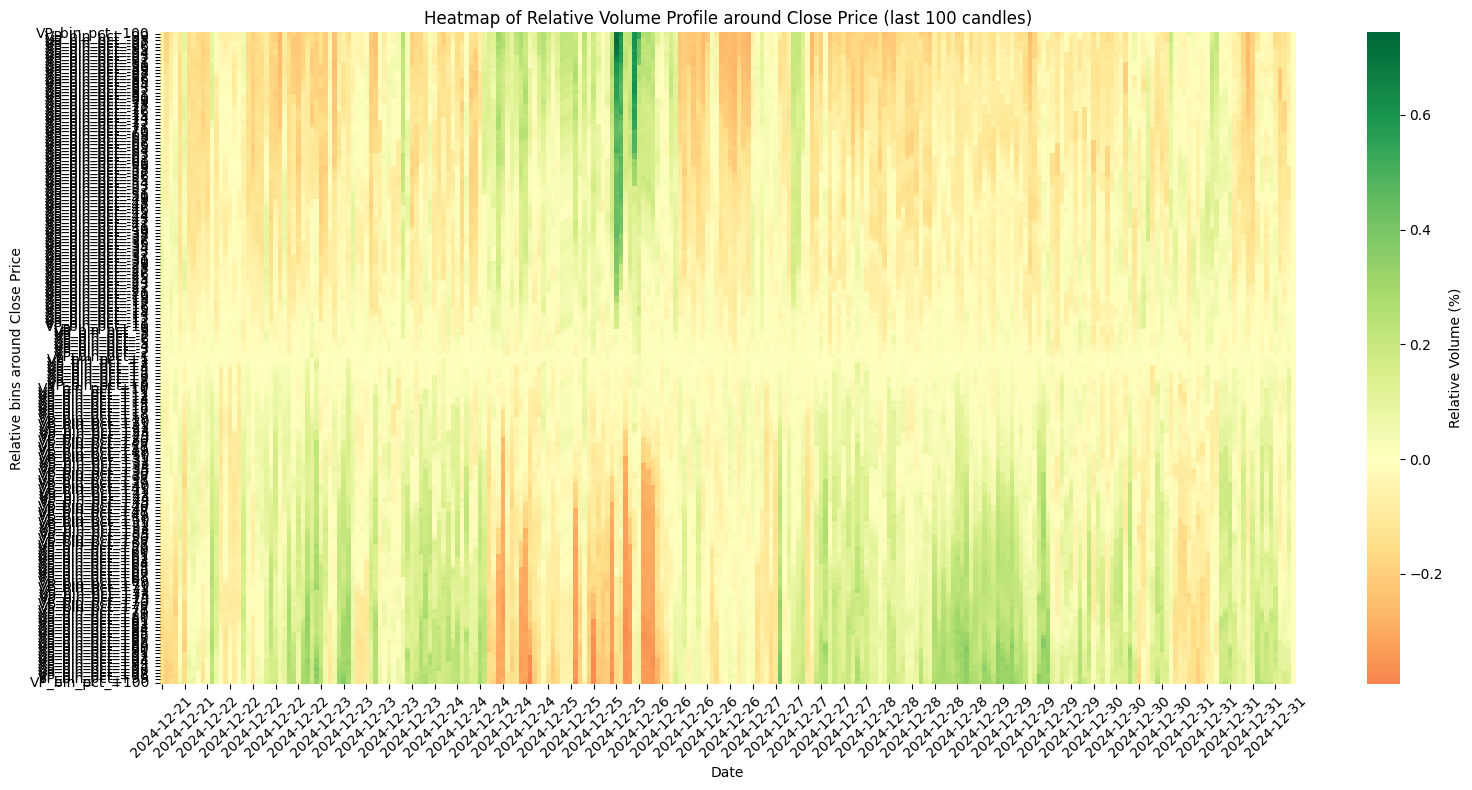

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Wybierz przykładowy fragment danych (ostatnie 100 świec)
df_plot = df.iloc[-250:].copy()

# Wybór kolumn procentowych VP
vp_cols = [col for col in df_plot.columns if col.startswith('VP_bin_pct_')]

# Ustawienie dat jako indeks (zakładam, że df ma kolumnę 'Date')
df_plot.index = pd.to_datetime(df_plot['Opened'])

# Heatmapa
plt.figure(figsize=(16, 8))
sns.heatmap(
    df_plot[vp_cols].T,
    cmap='RdYlGn',
    center=0,
    annot=False,
    cbar_kws={'label': 'Relative Volume (%)'}
)

# Opisy osi
plt.xlabel('Date')
plt.ylabel('Relative bins around Close Price')

plt.yticks(
    np.arange(len(vp_cols)) + 0.5,
    vp_cols,
    rotation=0
)

# Ustawienie osi X z datami (co kilka etykiet dla czytelności)
xticks_labels = df_plot.index.strftime('%Y-%m-%d')
xticks_positions = np.arange(len(xticks_labels))

plt.xticks(
    ticks=xticks_positions[::5] + 0.5,  # Co piątą datę, żeby było czytelnie
    labels=xticks_labels[::5],
    rotation=45
)

plt.title('Heatmap of Relative Volume Profile around Close Price (last 100 candles)')
plt.tight_layout()
plt.show()


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_vp_and_price_random(df: pd.DataFrame,
                             window: int = 250,
                             random_state: int | None = None) -> None:
    """
    Rysuje:
      • heatmapę Relative Volume Profile (kolumny 'VP_bin_pct_*')
      • wykres Close vs VWAP
    na LOSOWO wybranym podoknie o długości `window`.

    Parametry
    ----------
    df            : ramka z kolumnami 'Opened', 'VWAP', opcjonalnie 'Close'
                    i kolumnami zaczynającymi się od 'VP_bin_pct_'
    window        : liczba świec w oknie
    random_state  : int → powtarzalny wybór okna; None → prawdziwy los
    """
    if window > len(df):
        raise ValueError(f"`window` ({window}) jest większe niż długość df ({len(df)})")

    rng = np.random.default_rng(random_state)
    start = rng.integers(0, len(df) - window + 1)
    stop  = start + window
    df_slice = df.iloc[start:stop].copy()

    # ------------- ustawienia wspólne -------------
    vp_cols = [c for c in df_slice.columns if c.startswith('VP_bin_pct_')]
    if not vp_cols:
        raise ValueError("Brak kolumn 'VP_bin_pct_*' w ramce danych.")

    df_slice.index = pd.to_datetime(df_slice['Opened'])

    # ------------- HEATMAP VP ---------------------
    fig1, ax1 = plt.subplots(figsize=(16, 8))
    im = ax1.imshow(df_slice[vp_cols].T.values, aspect='auto', origin='lower')

    # Oś X – daty co (window // 50) świec, min 1
    step = max(1, window // 50)
    xticks = np.arange(0, window, step)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(df_slice.index.strftime('%Y-%m-%d')[::step],
                        rotation=45, ha='right')

    ax1.set_yticks(np.arange(len(vp_cols)))
    ax1.set_yticklabels(vp_cols)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Relative bins around VWAP")
    ax1.set_title(f"Heatmap VP – losowe okno {window} świec "
                  f"({df_slice.index[0].date()} → {df_slice.index[-1].date()})")

    cbar = fig1.colorbar(im, ax=ax1)
    cbar.set_label("Relative Volume (%)")
    fig1.tight_layout()

    # ------------- PRICE + VWAP -------------------
    fig2, ax2 = plt.subplots(figsize=(16, 6))
    if 'Close' in df_slice.columns:
        ax2.plot(df_slice.index, df_slice['Close'], label='Close')
    ax2.plot(df_slice.index, df_slice['VWAP'],  label='VWAP')

    ax2.set_xlabel("Date")
    ax2.set_ylabel("Price")
    ax2.set_title(f"Close vs VWAP – to samo okno")
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    fig2.tight_layout()

    plt.show()


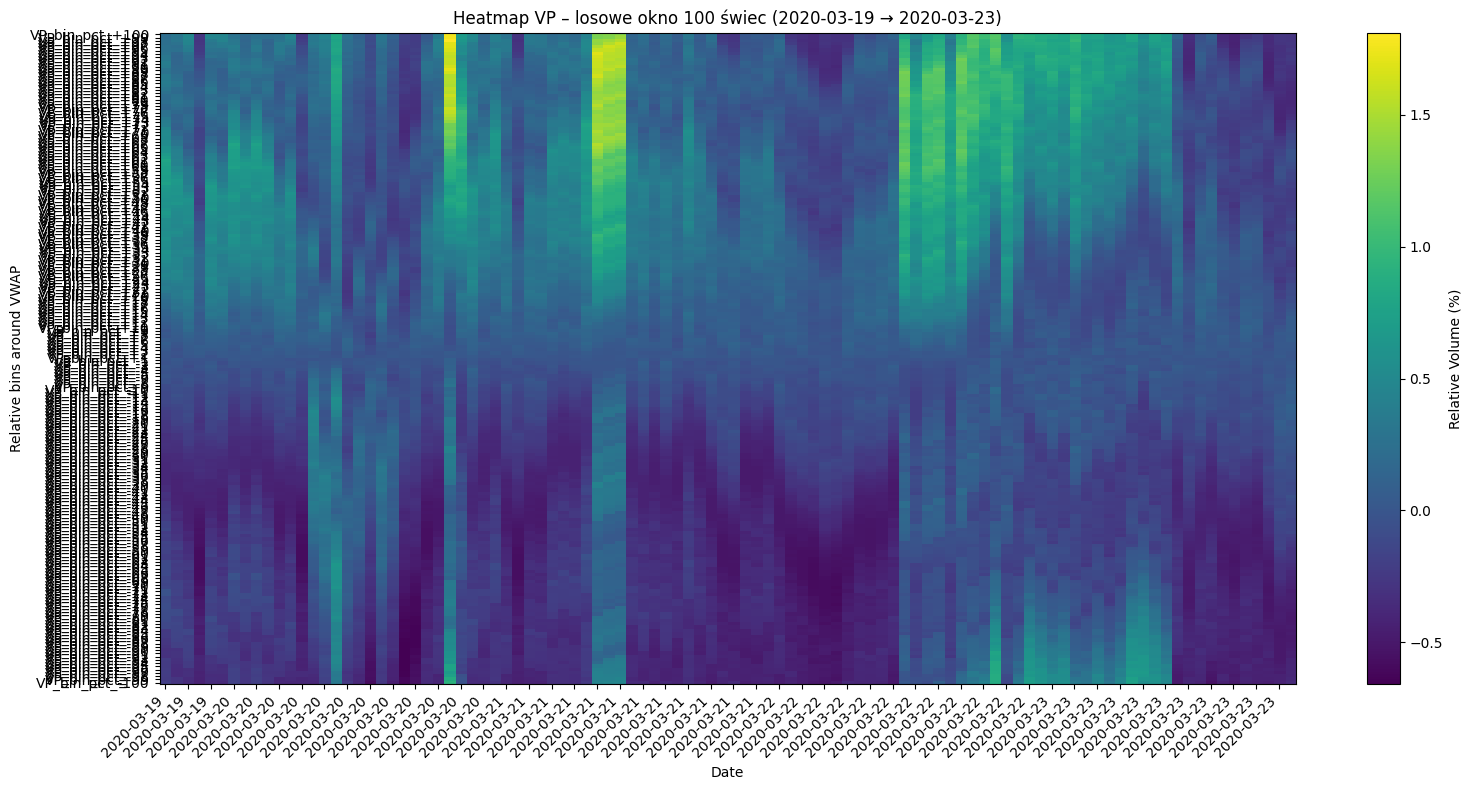

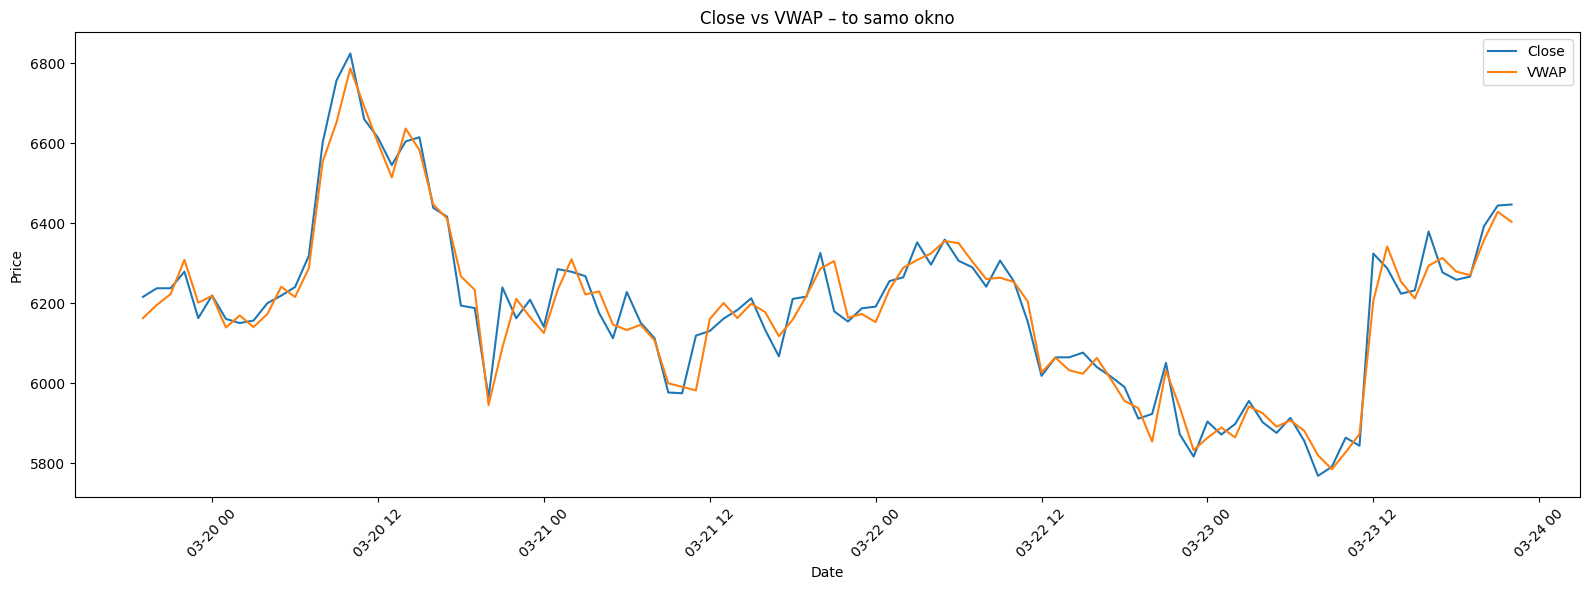

In [8]:
# Jednorazowo, prawdziwy los
plot_vp_and_price_random(df, window=100)

In [8]:
# # Calculate additional price aggregates
# df_final['hl2'] = (df_final['High'] + df_final['Low']) / 2
# df_final['hlc3'] = (df_final['High'] + df_final['Low'] + df_final['Close']) / 3
# df_final['ohlc4'] = (df_final['Open'] + df_final['High'] + df_final['Low'] + df_final['Close']) / 4
# df_final['hlcc4'] = (df_final['High'] + df_final['Low'] + 2 * df_final['Close']) / 4
# # Additional suggestion: average of Open and Close
# df_final['oc'] = (df_final['Open'] + df_final['Close']) / 2
# df_final['hlo3'] = (df_final['High'] + df_final['Low'] + df_final['Open']) / 3
# df_final['ohlc5'] = (df_final['Open'] + df_final['High'] + df_final['Low'] + df_final['Close'] + df_final['hl2']) / 5
# df_final['oc3'] = (df_final['Open'] + 2 * df_final['Close']) / 3
# df_final['ho2c'] = (2 * df_final['High'] + df_final['Open'] + df_final['Close']) / 4
# df_final['lo2c'] = (2 * df_final['Low'] + df_final['Open'] + df_final['Close']) / 4

# # Updated list of aggregates
# aggregates = ['Open', 'High', 'Low', 'Close', 'hl2', 'hlc3', 'ohlc4', 'hlcc4', 'oc',
#               'hlo3', 'ohlc5', 'oc3', 'ho2c', 'lo2c']

# # Calculate error metrics relative to VWAP for each aggregate
# metrics = []
# for agg in aggregates:
#     mae = np.mean(np.abs(df_final[agg] - df_final['VWAP']))       # Mean Absolute Error
#     rmse = np.sqrt(np.mean((df_final[agg] - df_final['VWAP'])**2))  # Root Mean Squared Error
#     mape = np.mean(np.abs(df_final[agg] - df_final['VWAP']) / df_final['VWAP']) * 100  # Mean Absolute Percentage Error
#     metrics.append({
#         'Aggregate': agg,
#         'MAE': mae,
#         'RMSE': rmse,
#         'MAPE': mape
#     })

# # Create a DataFrame with the computed metrics
# metrics_df = pd.DataFrame(metrics)

# # Sort and display the metrics in descending order for each metric column
# sorted_by_mae = metrics_df.sort_values(by='MAE', ascending=False)
# sorted_by_rmse = metrics_df.sort_values(by='RMSE', ascending=False)
# sorted_by_mape = metrics_df.sort_values(by='MAPE', ascending=False)

# print("Results sorted by MAE (descending):")
# print(sorted_by_mae)
# print("\nResults sorted by RMSE (descending):")
# print(sorted_by_rmse)
# print("\nResults sorted by MAPE (descending):")
# print(sorted_by_mape)

In [9]:
# # New aggregates approximating VWAP more closely

# # 1. Adjust hl2 slightly toward Close:
# df_final['hl2_adj1'] = df_final['hl2'] + 0.09 * (df_final['Close'] - df_final['hl2'])

# # 2. Adjust hl2 downward based on the gap between High and Close:
# df_final['hl2_adj2'] = df_final['hl2'] - 0.1 * (df_final['High'] - df_final['Close'])

# # 3. Weighted average of Low and Close (giving more weight to Close):
# df_final['weighted_low_close'] = 0.4 * df_final['Low'] + 0.6 * df_final['Close']

# # 4. Blend of hl2 and Close with more emphasis on hl2:
# df_final['weighted_hl2_close'] = 0.7 * df_final['hl2'] + 0.3 * df_final['Close']

# # 5. A weighted OHLC average giving większą wagę cenom Low i Close:
# df_final['weighted_ohlc'] = 0.2 * df_final['Open'] + 0.2 * df_final['High'] + 0.3 * df_final['Low'] + 0.3 * df_final['Close']

# # List of new aggregates to compare:
# new_aggregates = ['hl2_adj1', 'hl2_adj2', 'weighted_low_close', 'weighted_hl2_close', 'weighted_ohlc']

# # Compute error metrics relative to VWAP for each new aggregate:
# new_metrics = []
# for agg in new_aggregates:
#     mae = np.mean(np.abs(df_final[agg] - df_final['VWAP']))               # Mean Absolute Error
#     rmse = np.sqrt(np.mean((df_final[agg] - df_final['VWAP']) ** 2))         # Root Mean Squared Error
#     mape = np.mean(np.abs(df_final[agg] - df_final['VWAP']) / df_final['VWAP']) * 100  # Mean Absolute Percentage Error
#     new_metrics.append({
#         'Aggregate': agg,
#         'MAE': mae,
#         'RMSE': rmse,
#         'MAPE': mape
#     })

# new_metrics_df = pd.DataFrame(new_metrics)

# # Sort the results in descending order for each metric column:
# sorted_new_mae = new_metrics_df.sort_values(by='MAE', ascending=False)
# sorted_new_rmse = new_metrics_df.sort_values(by='RMSE', ascending=False)
# sorted_new_mape = new_metrics_df.sort_values(by='MAPE', ascending=False)

# print("New Aggregates - Sorted by MAE (descending):")
# print(sorted_new_mae)
# print("\nNew Aggregates - Sorted by RMSE (descending):")
# print(sorted_new_rmse)
# print("\nNew Aggregates - Sorted by MAPE (descending):")
# print(sorted_new_mape)


In [10]:
# def add_volume_profile_relative_features(df, bins=20, bins_back=2, bins_forward=2):
#     # Globalne ustalenie zakresu cenowego
#     price_min, price_max = df['Low'].min(), df['High'].max()
#     price_levels = np.linspace(price_min, price_max, bins + 1)

#     # Globalny profil wolumenu
#     volume_profile = np.zeros(bins)
#     for i in range(bins):
#         overlap = df[(df['High'] >= price_levels[i]) & (df['Low'] <= price_levels[i + 1])]
#         volume_profile[i] = overlap['Volume'].sum()

#     def get_bin_idx(price):
#         idx = np.searchsorted(price_levels, price, side='right') - 1
#         return np.clip(idx, 0, bins - 1)

#     df['VP_bin'] = df['VWAP'].apply(get_bin_idx)

#     # Procentowe wartości względem bieżącego binu
#     for shift in range(-bins_back, bins_forward + 1):
#         if shift == 0:
#             continue  # pomijamy bin aktualny, bo to punkt odniesienia
#         col_name = f'VP_bin_pct_{shift:+}'

#         def relative_pct(x, shift=shift):
#             current_vol = volume_profile[x]
#             neighbor_vol = volume_profile[np.clip(x + shift, 0, bins - 1)]
#             if current_vol == 0:
#                 return 0.0  # uniknięcie dzielenia przez zero
#             return (neighbor_vol - current_vol) / current_vol * 100

#         df[col_name] = df['VP_bin'].apply(relative_pct)

#     # Można zostawić lub usunąć bin pomocniczy
#     df.drop(columns=['VP_bin'], inplace=True)

#     return df

# # Przykładowe użycie:
# df = add_volume_profile_relative_features(df_final, bins=5000, bins_back=25, bins_forward=25)
